In [94]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import random
import os
import xgboost as xgb

from joblib import dump
from optuna.samplers import TPESampler
from sklearn.preprocessing import MinMaxScaler

# Fix random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
sampler = TPESampler(seed=seed)

optuna.logging.set_verbosity(optuna.logging.WARNING)

HYPERPARAMETERS_SEARCH = False

# Pre-processing input data

In [95]:
# train_df and test_df are created in eda notebook
if not os.path.exists('csv/train_df.csv') or not os.path.exists('csv/test_df.csv'):
	print('Please run the eda notebook first')
	exit()
train_df = pd.read_csv('csv/train_df.csv')
test_df = pd.read_csv('csv/test_df.csv')
target = 'total_time_target'
features = test_df.columns.copy().drop(target).drop(['benchmark','brand_raw', 'brand_raw_target','vendor_id_raw', 'arch'])

# Spearman U Kendall correlation feature selection > 0.4
# features = ["total_time","max_ram_usage","brk","munmap","rss","vms","shared","data"]
# mean error: 2.6298196518300885 | std error: 6.704351557190401

# Split data
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Normalize data
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

In [96]:
if not os.path.exists('../models/x_scaler.joblib') or not os.path.exists('../models/y_scaler.joblib'):
	dump(x_scaler, '../models/x_scaler.joblib')
	dump(y_scaler, '../models/y_scaler.joblib')

# Model: XGBoost

In [97]:
def inv_scaling(y, y_scaler):
    return y_scaler.inverse_transform(y.reshape(-1, 1))

# Hyperparameters Optimization

In [98]:
def objective(trial: optuna.Trial, X_train, y_train, X_test, y_test):
	dtrain = xgb.DMatrix(X_train, label=y_train)
	dtest = xgb.DMatrix(X_test, label=y_test)
	
	# Definimos los hiperparámetros a buscar (XGBoost)
	param = {
		"verbosity": 0,
		"device": "cuda",
		"objective": "reg:squarederror",
		"eval_metric": "rmse",
		"booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
		# L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
		"learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
	}
	num_boost_round = trial.suggest_int("num_boost_round", 10, 1000, step=10)
    
	if param["booster"] in ["gbtree", "dart"]:
		# maximum depth of the tree, signifies complexity of the tree.
		param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
		# minimum child weight, larger the term more conservative the tree.
		param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
		param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
		# defines how selective algorithm is.
		param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
		param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

	if param["booster"] == "dart":
		param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
		param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
		param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
		param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

	# training
	evals_result = {}
	xgb.train(
		param, 
		dtrain,
		num_boost_round=num_boost_round,
		evals=[(dtrain, "train"), (dtest, "test")],
		evals_result=evals_result,
		verbose_eval=False,
		early_stopping_rounds=25
	)
	loss = evals_result['train']['rmse'][-1]
	val_loss = evals_result['test']['rmse'][-1]
	print(f"Trial: {trial.number} - RMSE Loss : {loss} - RMSE Val Loss: {val_loss}")
	return val_loss

n_trials = 100
study = None

In [99]:
if HYPERPARAMETERS_SEARCH:
	study = optuna.create_study(direction='minimize', sampler=sampler)
	study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=n_trials)

In [100]:
if study is not None:
	print(f'Number of trials: {len(study.trials)}')
	trial = study.best_trial
	print(f'Best trial: {trial.number}')
	print(f'Best params: {trial.params}')
	print(f'Best validation loss: {y_scaler.inverse_transform(np.reshape(trial.value, (-1,1))).item()}')

# Training

In [101]:
# hyperparameters
params = {
	"device": "cuda",
	"objective": "reg:squarederror",
	"eval_metric": "rmse",
}
if study is not None:
	num_boost_round = study.best_trial.params['num_boost_round']
	params.update(*study.best_trial.params)
	params.pop('num_boost_round')
else:
	num_boost_round = 100

In [102]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

evals_result = {}
model = xgb.train(
	params, 
	dtrain,
	num_boost_round=num_boost_round,
	evals=[(dtrain, "train"), (dtest, "test")],
	evals_result=evals_result,
	early_stopping_rounds=10
)

[0]	train-rmse:0.03740	test-rmse:0.03161
[1]	train-rmse:0.02651	test-rmse:0.02194
[2]	train-rmse:0.01889	test-rmse:0.01553
[3]	train-rmse:0.01360	test-rmse:0.01075
[4]	train-rmse:0.00989	test-rmse:0.00765
[5]	train-rmse:0.00727	test-rmse:0.00590
[6]	train-rmse:0.00548	test-rmse:0.00469
[7]	train-rmse:0.00420	test-rmse:0.00418


[8]	train-rmse:0.00340	test-rmse:0.00384
[9]	train-rmse:0.00288	test-rmse:0.00371
[10]	train-rmse:0.00246	test-rmse:0.00364
[11]	train-rmse:0.00223	test-rmse:0.00358
[12]	train-rmse:0.00202	test-rmse:0.00355
[13]	train-rmse:0.00182	test-rmse:0.00347
[14]	train-rmse:0.00168	test-rmse:0.00332
[15]	train-rmse:0.00162	test-rmse:0.00322
[16]	train-rmse:0.00150	test-rmse:0.00299
[17]	train-rmse:0.00145	test-rmse:0.00302
[18]	train-rmse:0.00142	test-rmse:0.00304
[19]	train-rmse:0.00137	test-rmse:0.00302
[20]	train-rmse:0.00132	test-rmse:0.00300
[21]	train-rmse:0.00130	test-rmse:0.00299
[22]	train-rmse:0.00123	test-rmse:0.00298
[23]	train-rmse:0.00122	test-rmse:0.00297
[24]	train-rmse:0.00120	test-rmse:0.00296
[25]	train-rmse:0.00118	test-rmse:0.00293
[26]	train-rmse:0.00112	test-rmse:0.00288
[27]	train-rmse:0.00109	test-rmse:0.00286
[28]	train-rmse:0.00105	test-rmse:0.00286
[29]	train-rmse:0.00103	test-rmse:0.00285
[30]	train-rmse:0.00101	test-rmse:0.00279
[31]	train-rmse:0.00100	test-rmse:0.

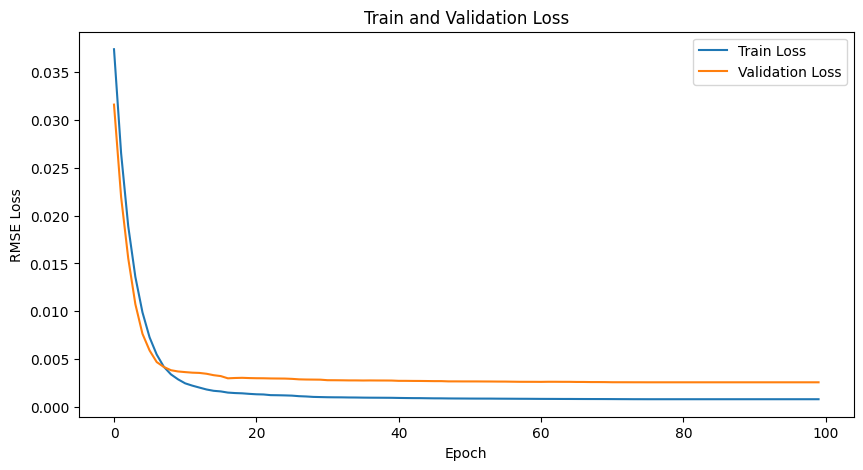

In [103]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(evals_result['train']['rmse'], label='Train Loss')
plt.plot(evals_result['test']['rmse'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')
plt.legend()
plt.show()

In [104]:
# save model
model.save_model(f'../models/xgboost_model.json')

# Describe Validation

In [105]:
model = xgb.Booster()
model.load_model('../models/xgboost_model.json')

In [106]:
def describe_val(model, X, y, y_scaler):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}
	dtest = xgb.DMatrix(X)
	predictions = model.predict(dtest)
	predictions = inv_scaling(predictions, y_scaler)
	y_scaled = inv_scaling(y, y_scaler)
	index_min = np.argmin(np.abs(predictions - y_scaled))
	min_instance["prediction"] = predictions[index_min].item()
	min_instance["actual"] = y_scaled[index_min].item()
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y_scaled))
	max_instance["prediction"] = predictions[index_max].item()
	max_instance["actual"] = y_scaled[index_max].item()
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions

In [107]:
test_df_og = pd.read_csv('csv/test_df.csv')

In [108]:
_, _, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled = inv_scaling(y_test, y_scaler)
df = pd.DataFrame(predictions, columns=['predictions'])
df['actual'] = y_scaled
df.to_csv('csv/predictions_xgboost.csv', index=False)

In [109]:
print("Validation set single thread model")
min_instance, max_instance, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled = inv_scaling(y_test, y_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model
Mean prediction: 23.604955673217773 | Std actual: 41.9148063659668
Mean actual: 23.631032844733987 | Std actual: 41.60096829835196
Mean Error: 0.9766421382754726 | Std Error: 2.095736600201618
Min instance
total_time                                                             1.14
total_cpu_usage                                                        0.99
max_ram_usage                                                     22.097656
brand_raw                          Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    56
l2_cache_size                                                          70.0
l3_cache_size                                                          42.0
l2_cache_line_size                                                      256

In [110]:
# get index of total_time_target of pcs that are not in train set
index = test_df_og[test_df_og['brand_raw_target'].isin(['Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz','Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz'])].index
X_test_notrainpc = X_test[index]
y_test_notrainpc = y_test[index]
test_df_og_notrainpc = test_df_og.iloc[index].reset_index(drop=True)
min_instance, max_instance, predictions = describe_val(model, X_test_notrainpc, y_test_notrainpc, y_scaler)
y_scaled = inv_scaling(y_test_notrainpc, y_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Validation set single thread model with total_time_target for pcs that are not in train set")
print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og_notrainpc.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og_notrainpc.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model with total_time_target for pcs that are not in train set
Mean prediction: 20.37563705444336 | Std actual: 3.0761351585388184
Mean actual: 20.84064377682403 | Std actual: 3.445857034386544
Mean Error: 1.2209428359919863 | Std Error: 1.1390247468330597
Min instance
total_time                                                                 21.89
total_cpu_usage                                                              1.0
max_ram_usage                                                          31.433594
brand_raw                         11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
vendor_id_raw                                                       GenuineIntel
arch                                                                      X86_64
count                                                                          8
l2_cache_size                                                                5.0
l3_cache_size                                        

# SHAP Analysis

In [111]:
# TODO: Do SHAP AGAIN
test_df_og = test_df_og.iloc[::30]
y_prediction = inv_scaling(model.predict(xgb.DMatrix(X_test[::30])), y_scaler)
test_df_og.shape

(246, 43)

In [112]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(xgb.DMatrix(X_test[::30]))
X_test_non_scaled = x_scaler.inverse_transform(X_test[::30])
shap.initjs()

In [113]:
shap.force_plot(explainer.expected_value, shap_values, X_test_non_scaled, feature_names=features)

Prediction: 0.9255505800247192 | Actual: 0.9


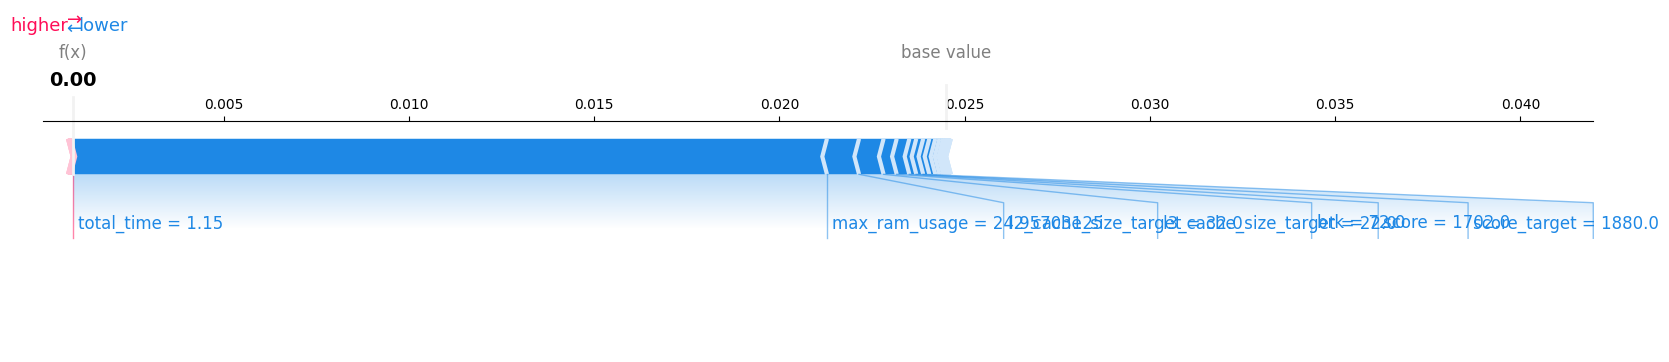

In [114]:
instance = 108
print(f"Prediction: {y_prediction[instance].item()} | Actual: {test_df_og.iloc[instance]['total_time_target']}")
shap.force_plot(explainer.expected_value, shap_values[instance], X_test_non_scaled[instance], feature_names=features, matplotlib=True)

Prediction: 17.901945114135742 | Actual: 17.86


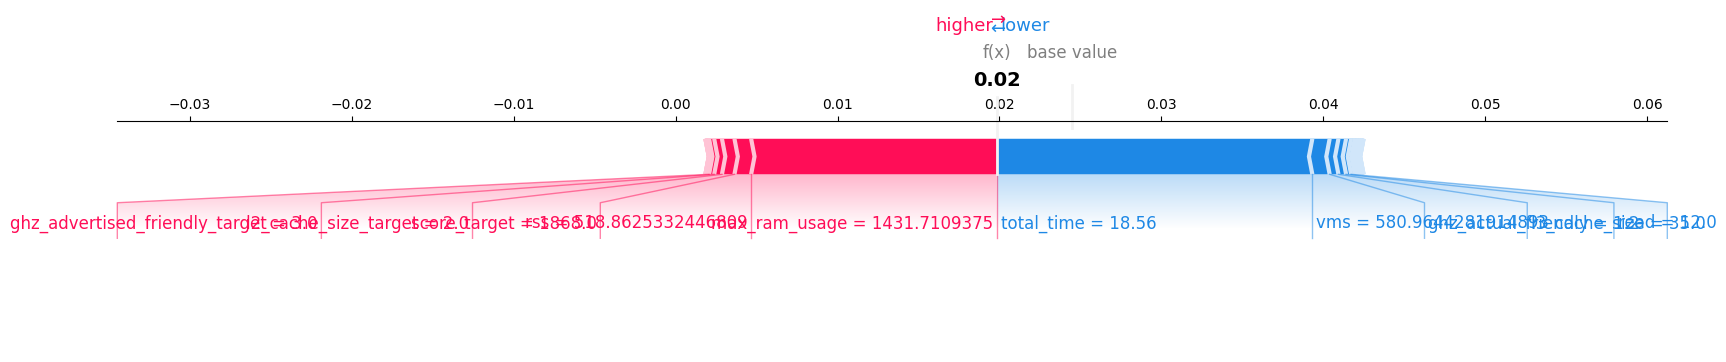

In [115]:
instance = 87
print(f"Prediction: {y_prediction[instance].item()} | Actual: {test_df_og.iloc[instance]['total_time_target']}")
shap.force_plot(explainer.expected_value, shap_values[instance], X_test_non_scaled[instance], feature_names=features, matplotlib=True)

Prediction: 274.0120544433594 | Actual: 269.24


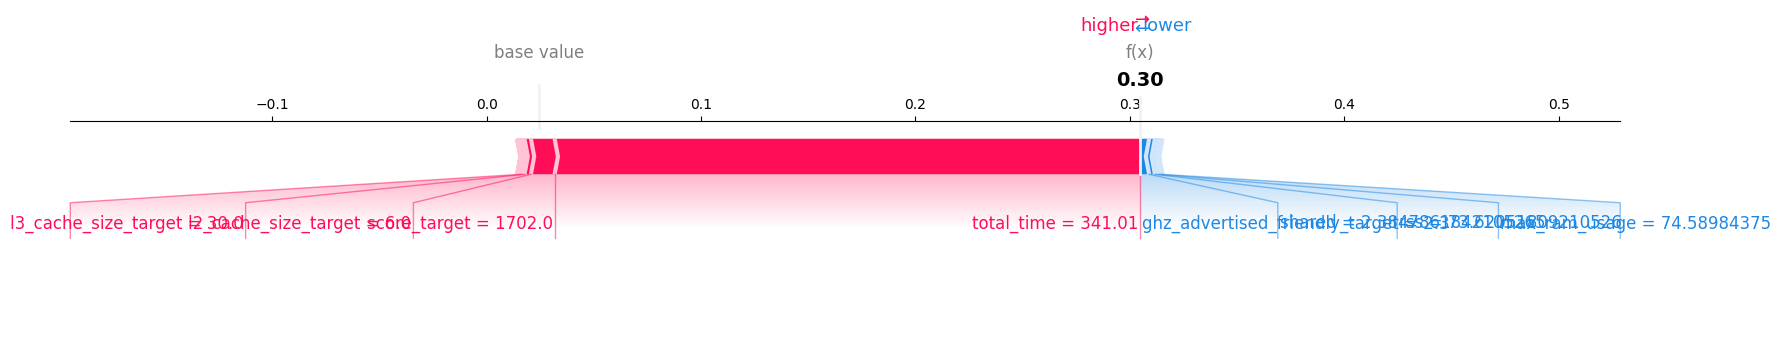

In [116]:
instance = 170
print(f"Prediction: {y_prediction[instance].item()} | Actual: {test_df_og.iloc[instance]['total_time_target']}")
shap.force_plot(explainer.expected_value, shap_values[instance], X_test_non_scaled[instance], feature_names=features, matplotlib=True)

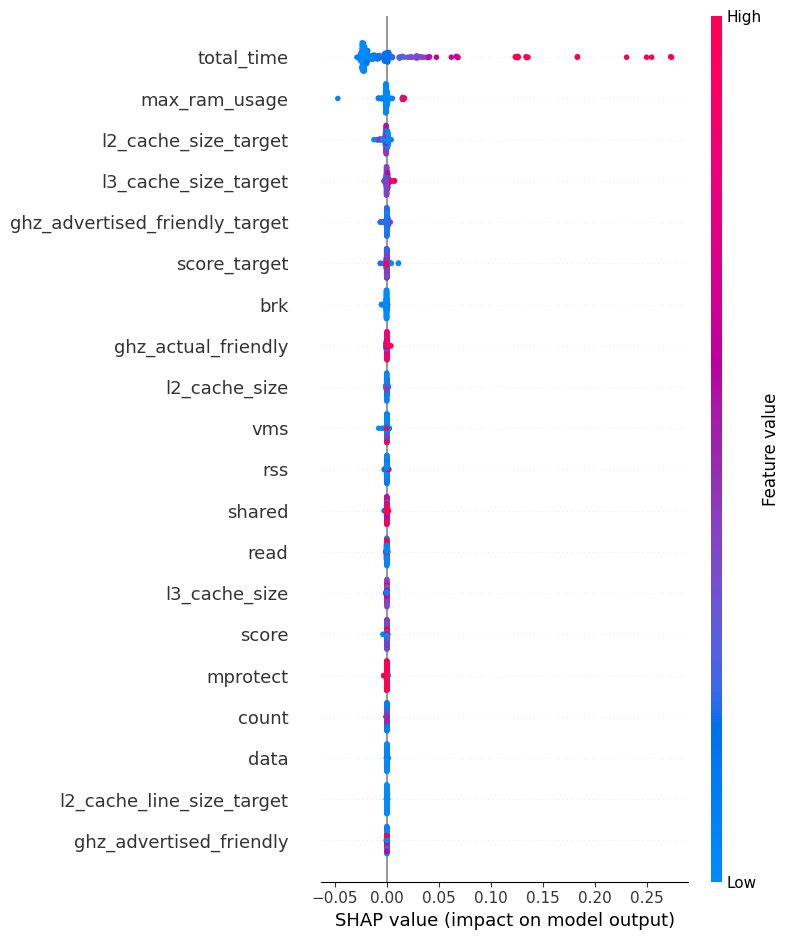

In [117]:
# Sumarize the effects of all the features
shap.summary_plot(shap_values, X_test_non_scaled, feature_names=features)

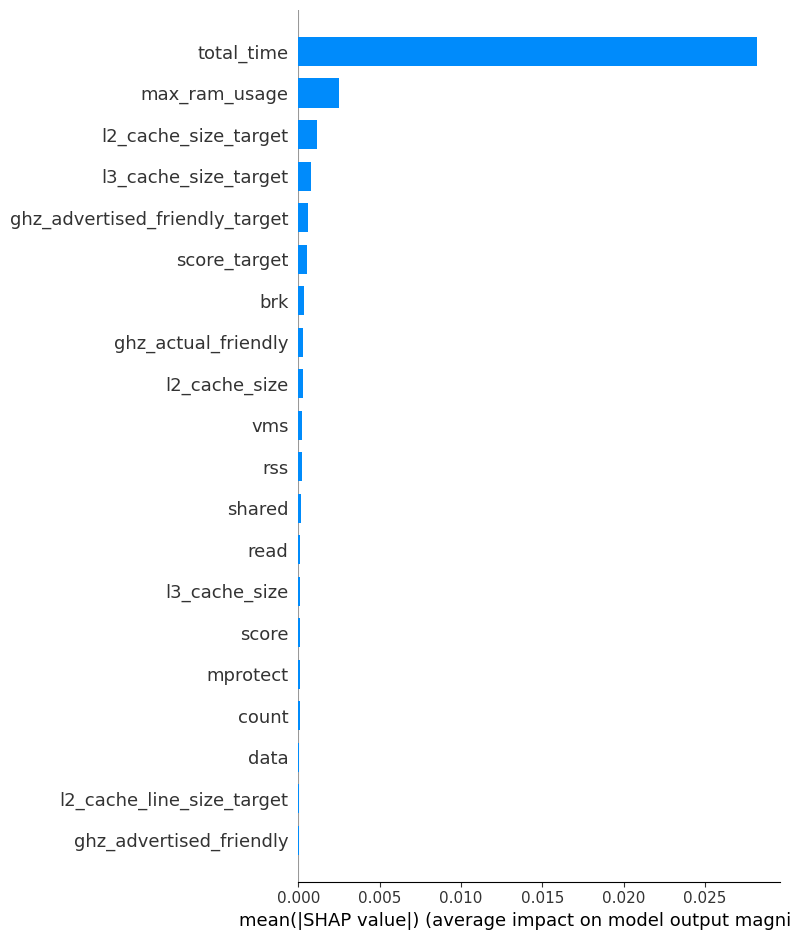

In [118]:
shap.summary_plot(shap_values, X_test_non_scaled, feature_names=features, plot_type='bar')

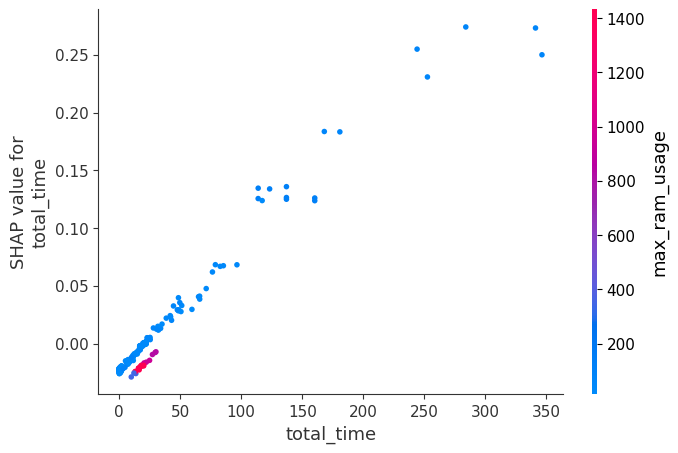

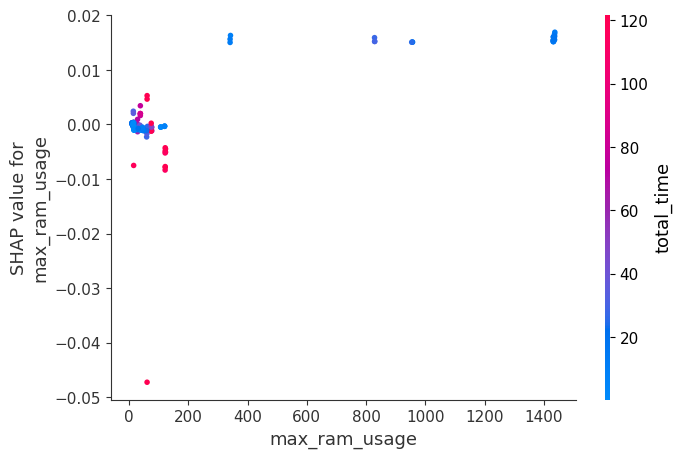

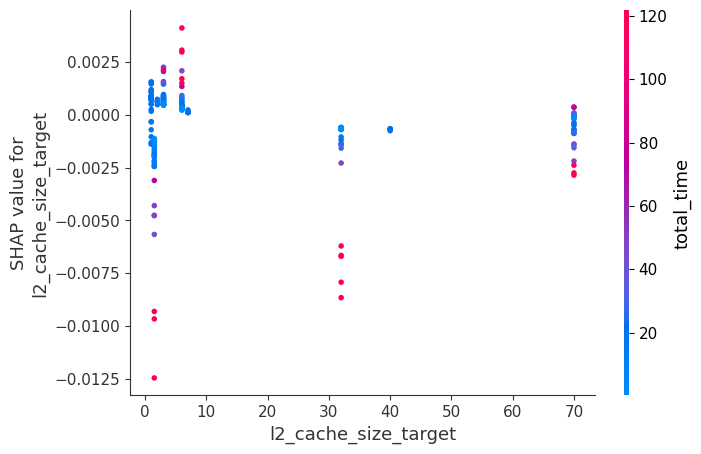

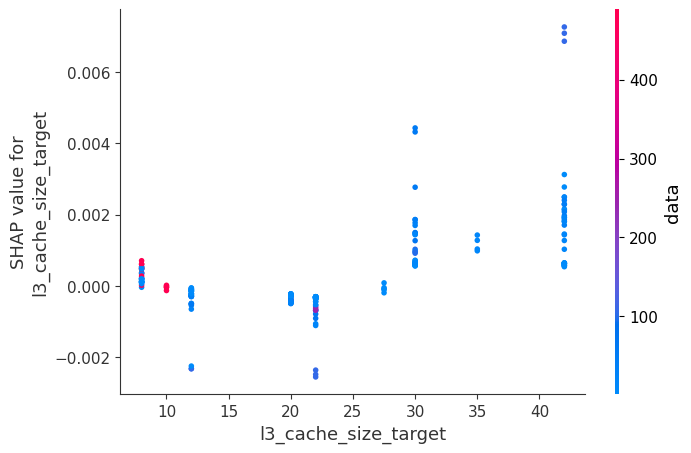

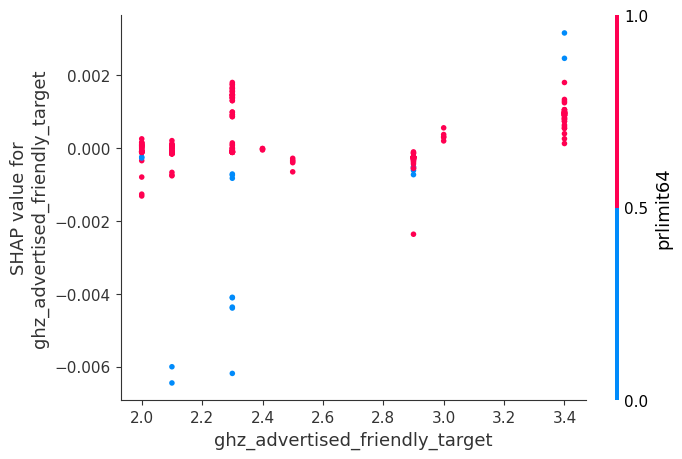

In [119]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the test set)
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))
for i in range(5):
    # shap.common.approximate_interactions is used to pick what seems to be the strongest interaction 
    shap.dependence_plot(top_inds[i], shap_values, X_test_non_scaled, feature_names=features)